In [1]:
import cv2
import numpy as np

def crop_jellyfish_from_yolo_box(img, x_center, y_center, w, h):
    """
    img      : image OpenCV (BGR) -> np.array
    x_center : centre bbox normalisé (entre 0 et 1, en largeur)
    y_center : centre bbox normalisé (entre 0 et 1, en hauteur)
    w        : largeur bbox normalisée
    h        : hauteur bbox normalisée

    return   : image recadrée sur la bbox (np.array)
    """
    H, W, _ = img.shape  # hauteur, largeur

    # Convertir coordonnées normalisées -> pixels
    box_w = w * W
    box_h = h * H
    cx = x_center * W
    cy = y_center * H

    x1 = int(cx - box_w / 2)
    y1 = int(cy - box_h / 2)
    x2 = int(cx + box_w / 2)
    y2 = int(cy + box_h / 2)

    # Sécuriser (éviter de sortir de l'image)
    x1 = max(0, x1)
    y1 = max(0, y1)
    x2 = min(W, x2)
    y2 = min(H, y2)

    # Crop
    crop = img[y1:y2, x1:x2]

    return crop


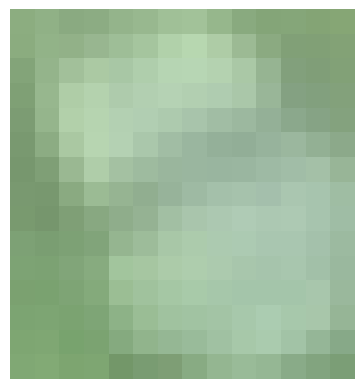

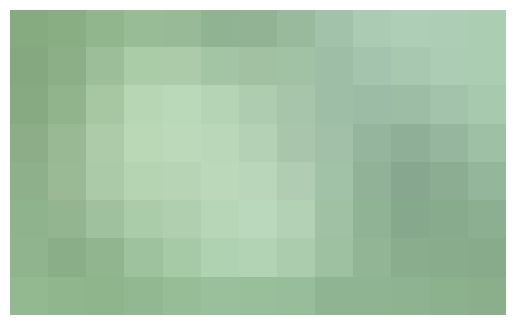

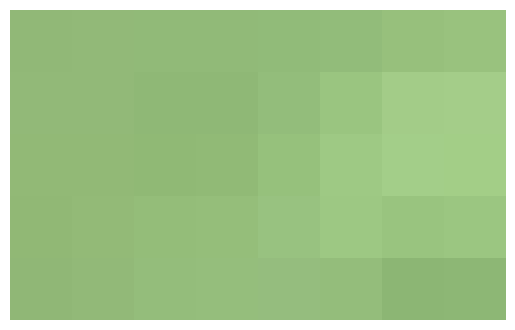

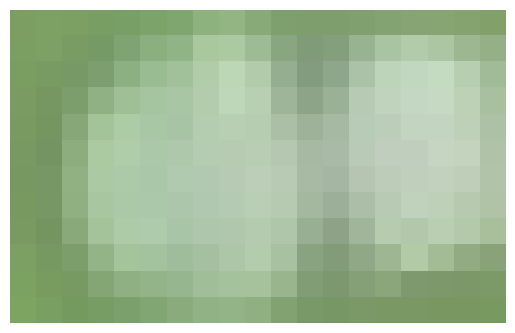

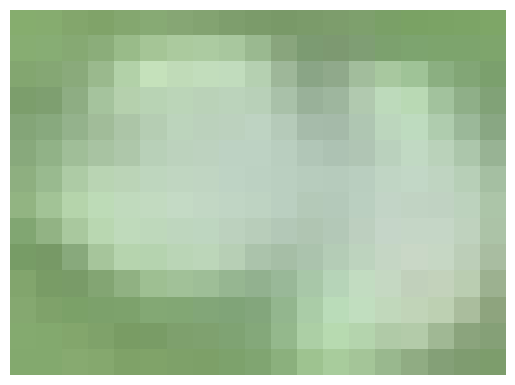

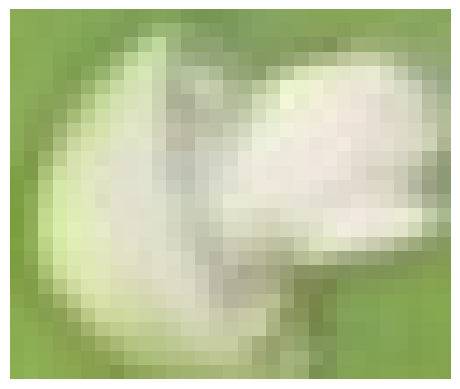

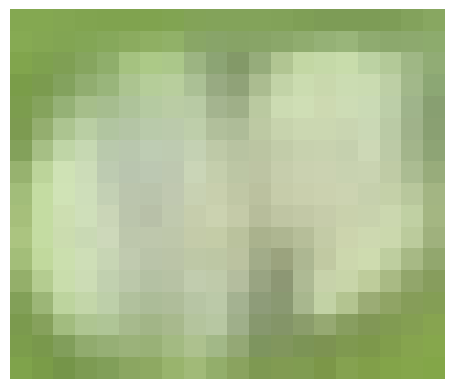

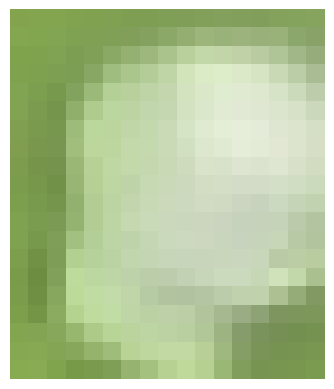

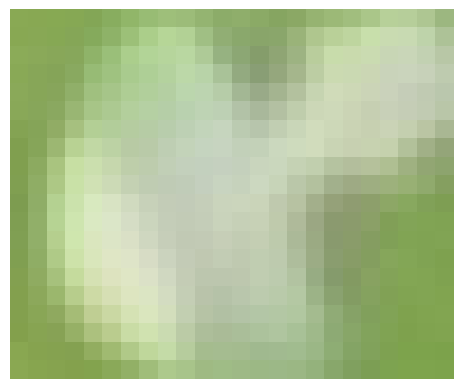

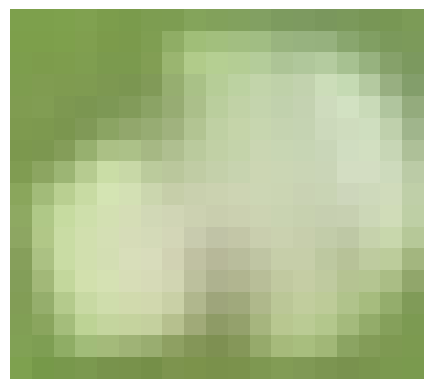

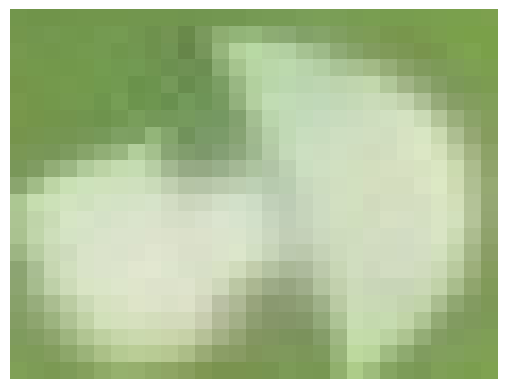

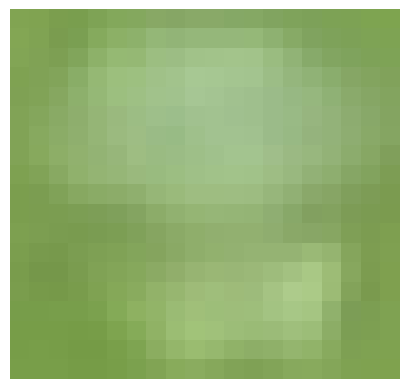

In [2]:
import cv2

# Charger l'image
img_path = "frame_00724.jpg"
label_path = "frame_00724.txt"

img = cv2.imread(img_path)

# Lire le fichier .txt correspondant
with open(label_path, "r") as f:
    lines = f.readlines()

for line in lines:
    cls_id, x_c, y_c, w, h = map(float, line.split())
    # cls_id = 0 (pulse) ou 1 (no_pulse)

    crop = crop_jellyfish_from_yolo_box(img, x_c, y_c, w, h)

    # Afficher avec matplotlib (plus simple dans Colab)
    import matplotlib.pyplot as plt
    plt.imshow(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()


# Intervalle de couleurs appartenant à la meduse
Ici, on cherche à définir l’intervalle de couleurs correspondant à la méduse afin de pouvoir s’appuyer dessus pour compter le nombre de pixels qui la composent.

Objectif final

Obtenir un intervalle de couleurs (en HSV ou RGB) permettant d’isoler la méduse du fond → utile pour :

segmentation

calcul précis de l’aire en pixels

vérification du tracking YOLO

filtrer les reflets (échos du soleil)

1. Imports + chargement image & label

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


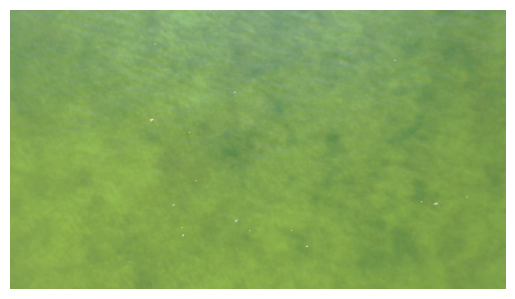

In [4]:
# Charger l'image (dans /content si tu l'as uploadée via Colab)
img = cv2.imread("frame_00724.jpg")

# Afficher pour vérifier
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()


In [5]:
# Lire la première ligne du label YOLO
with open("frame_00724.txt", "r") as f:
    line = f.readline().strip()

print("Ligne du label :", line)


Ligne du label : 15 0.292708 0.122454 0.003646 0.006944


In [6]:
# Découper et convertir en float
values = line.split()
cls, x_center, y_center, w, h = map(float, values)
print("classe =", cls, "x_c =", x_center, "y_c =", y_center, "w =", w, "h =", h)


classe = 15.0 x_c = 0.292708 y_c = 0.122454 w = 0.003646 h = 0.006944


2. Convertir la box YOLO → pixels et faire le crop

Taille image : 3840 x 2160
Box pixels : x1,y1 = 1116 257  x2,y2 = 1130 271


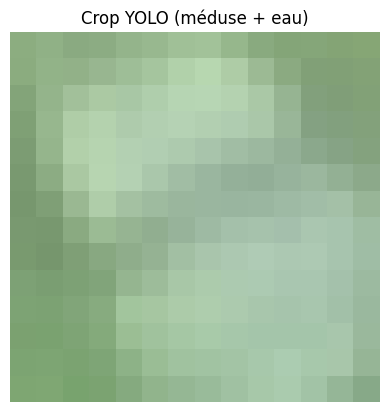

In [7]:
# Taille de l'image
H, W, _ = img.shape
print("Taille image :", W, "x", H)

# Taille et centre de la box en pixels
box_w = int(w * W)
box_h = int(h * H)
cx = int(x_center * W)
cy = int(y_center * H)

# Coins de la box
x1 = int(cx - box_w / 2)
y1 = int(cy - box_h / 2)
x2 = int(cx + box_w / 2)
y2 = int(cy + box_h / 2)

# Sécuriser dans les bornes de l'image
x1 = max(0, x1)
y1 = max(0, y1)
x2 = min(W, x2)
y2 = min(H, y2)

print("Box pixels : x1,y1 =", x1, y1, " x2,y2 =", x2, y2)

# Crop = zone de la méduse + eau autour
crop = img[y1:y2, x1:x2]

plt.imshow(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
plt.title("Crop YOLO (méduse + eau)")
plt.axis("off")
plt.show()


3. Préparer les données pour K-Means (dans l’espace HSV)

In [8]:
# Conversion du crop en HSV (plus adapté pour séparer couleurs)
crop_hsv = cv2.cvtColor(crop, cv2.COLOR_BGR2HSV)

# Récupérer H, S, V sous forme (N_pixels, 3)
h, w_crop, _ = crop_hsv.shape
pixels = crop_hsv.reshape(-1, 3)   # chaque ligne = [H, S, V]

print("Nombre de pixels dans le crop :", pixels.shape[0])


Nombre de pixels dans le crop : 196


4. Lancer K-Means (k=2 : eau vs méduse)

In [9]:
# On cherche 2 clusters : 1 pour l'eau, 1 pour la méduse
kmeans = KMeans(n_clusters=2, random_state=0, n_init=10)
kmeans.fit(pixels)

labels = kmeans.labels_        # étiquette de cluster pour chaque pixel
centers = kmeans.cluster_centers_  # centre HSV de chaque cluster

print("Centres de clusters (HSV) :")
for i, c in enumerate(centers):
    print(f"Cluster {i} : H={c[0]:.1f}, S={c[1]:.1f}, V={c[2]:.1f}")


Centres de clusters (HSV) :
Cluster 0 : H=60.7, S=42.2, V=194.5
Cluster 1 : H=53.9, S=65.6, V=165.7


# 5. Choisir automatiquement le cluster "méduse"
Heuristique simple (à adapter selon ce que tu observes) :

L’eau = souvent plus bleutée et/ou plus sombre

La méduse = plus claire (V plus élevé), souvent moins saturée

On va choisir le cluster avec la plus grande valeur moyenne de V comme méduse :

In [10]:
# On choisit le cluster avec la plus grande moyenne de V comme "méduse"
cluster_meduse = np.argmax(centers[:, 2])  # colonne 2 = V
print("Cluster supposé 'méduse' :", cluster_meduse)


Cluster supposé 'méduse' : 0


6. Construire un masque “méduse” dans le crop

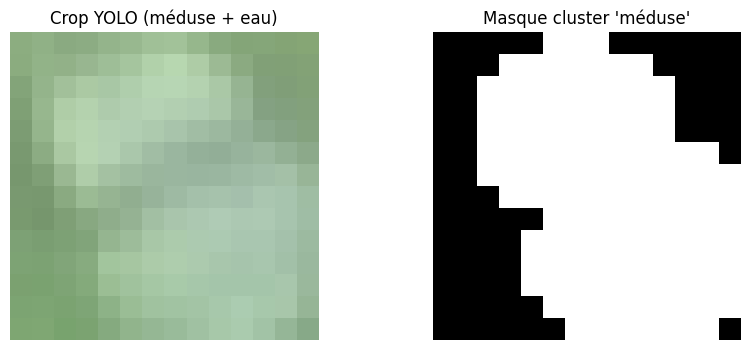

In [11]:
# labels (1D) -> on remet sous la forme de l'image du crop
labels_image = labels.reshape(h, w_crop)

# Masque binaire : 255 là où le pixel appartient au cluster "méduse"
mask_meduse = (labels_image == cluster_meduse).astype(np.uint8) * 255

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Crop YOLO (méduse + eau)")
plt.imshow(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Masque cluster 'méduse'")
plt.imshow(mask_meduse, cmap="gray")
plt.axis("off")

plt.show()


7. Appliquer le masque sur le crop pour isoler la méduse

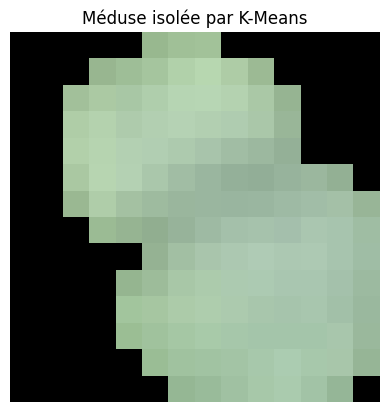

In [12]:
# Appliquer le masque sur le crop (on remet en BGR)
masked = cv2.bitwise_and(crop, crop, mask=mask_meduse)

plt.imshow(cv2.cvtColor(masked, cv2.COLOR_BGR2RGB))
plt.title("Méduse isolée par K-Means")
plt.axis("off")
plt.show()


8. Extraire les couleurs HSV uniquement sur la méduse

In [13]:
# On réutilise crop_hsv (HSV) et le masque
hsv_meduse = crop_hsv[mask_meduse == 255]   # ne garde que les pixels où la méduse est présente

H_vals = hsv_meduse[:, 0]
S_vals = hsv_meduse[:, 1]
V_vals = hsv_meduse[:, 2]

print("H (min-max) :", H_vals.min(), "-", H_vals.max())
print("S (min-max) :", S_vals.min(), "-", S_vals.max())
print("V (min-max) :", V_vals.min(), "-", V_vals.max())


H (min-max) : 53 - 69
S (min-max) : 35 - 57
V (min-max) : 174 - 215


--------------------------------------



--------------------------------------



1️⃣Construction d'un intervalle HSV “méduse”

In [14]:
import numpy as np

# Valeurs observées
H_min, H_max = 53, 69
S_min, S_max = 35, 57
V_min, V_max = 174, 215

# On élargit un peu pour être plus tolérant
lower = np.array([max(0,   H_min - 5),
                  max(0,   S_min - 10),
                  max(0,   V_min - 10)], dtype=np.uint8)

upper = np.array([min(179, H_max + 5),
                  min(255, S_max + 10),
                  min(255, V_max + 10)], dtype=np.uint8)

print("lower =", lower)
print("upper =", upper)


lower = [ 48  25 164]
upper = [ 74  67 225]


2️⃣Tester cet intervalle sur une image complète

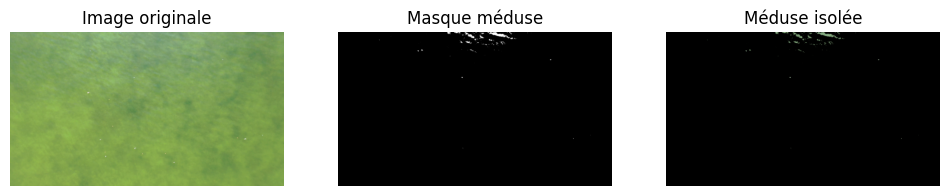

In [15]:
img_bgr = cv2.imread("frame_00724.jpg")
img_hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)

mask = cv2.inRange(img_hsv, lower, upper)
res  = cv2.bitwise_and(img_bgr, img_bgr, mask=mask)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.title("Image originale")
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Masque méduse")
plt.imshow(mask, cmap="gray")
plt.axis("off")

plt.subplot(1,3,3)
plt.title("Méduse isolée")
plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.show()


# CREATION DU TABLEAU

Importation du fichier trajecoire meduses

---



In [21]:

import pandas as pd

# 1. Importer le tableau existant (fourni par le groupe)
df = pd.read_csv("trajectoires_meduses.csv", sep=";")


# Vérification rapide du contenu
print("Colonnes existantes :", df.columns)
df.head()


Colonnes existantes : Index(['jelly_id', 'frame_idx', 'x_center', 'y_center', 'width', 'height',
       'marked'],
      dtype='object')


,jelly_id,frame_idx,x_center,y_center,width,height,marked
0,0,0,62.00064,1281.00096,21.99936,21.99960,0
1,0,1,64.50048,1280.49984,24.99840,20.99952,0
2,0,2,64.50048,1279.00080,21.00096,19.99944,0
3,0,3,68.50176,1277.49960,23.00160,22.99968,0
4,0,4,71.00160,1277.00064,21.99936,21.99960,0


2. Ajout de la colonne 'nb_pixels'
Le nombre de pixels est estimé comme l'aire de la bounding box YOLO
(largeur × hauteur)

In [22]:

df["nb_pixels"] = df["width"] * df["height"]

# Vérification des nouvelles colonnes
df[["width", "height", "nb_pixels"]].head()


,width,height,nb_pixels
0,21.99936,21.99960,483.977120
1,24.99840,20.99952,524.954401
2,21.00096,19.99944,420.007439
3,23.00160,22.99968,529.029439
4,21.99936,21.99960,483.977120


3. Sauvegarde du tableau mis à jour

In [25]:


# Sauvegarde au format CSV
df.to_csv("trajectoires_meduses_avec_pixels.csv", index=False)

# Sauvegarde au format Excel (optionnelle)
df.to_excel("trajectoires_meduses_avec_pixels.xlsx", index=False)

print("Tableau final sauvegardé avec la colonne 'nb_pixels'")


Tableau final sauvegardé avec la colonne 'nb_pixels'


importation du tableau

In [28]:
from google.colab import files
files.download("trajectoires_meduses_avec_pixels.xlsx")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#lissage d'image